[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/danpele/Time-Series-Analysis/blob/main/chapter4_lecture_notebook.ipynb)

---

# Chapter 4: SARIMA Models for Seasonal Time Series

**Course:** Time Series Analysis and Forecasting  
**Program:** Bachelor program, Faculty of Cybernetics, Statistics and Economic Informatics, Bucharest University of Economic Studies, Romania  
**Academic Year:** 2025-2026

---

## Learning Objectives

By the end of this notebook, you will be able to:
1. Identify and characterize seasonal patterns in time series
2. Apply seasonal differencing to remove stochastic seasonality
3. Understand the SARIMA$(p,d,q) \times (P,D,Q)_s$ notation
4. Fit SARIMA models using Python
5. Interpret seasonal ACF/PACF patterns
6. Generate seasonal forecasts with confidence intervals

## Setup and Imports

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Time series specific
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats

# Plotting style - clean, professional
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['savefig.facecolor'] = 'none'
plt.rcParams['savefig.transparent'] = True
plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.grid'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# Colors (IDA color scheme)
COLORS = {
    'blue': '#1A3A6E',
    'red': '#DC3545',
    'green': '#2E7D32',
    'orange': '#E67E22',
    'gray': '#666666'
}

print("All libraries loaded successfully!")

All libraries loaded successfully!


## 1. Introduction to Seasonality

**Seasonality** is a repeating pattern that occurs at regular intervals:
- Monthly retail sales peak in December
- Quarterly GDP shows annual patterns
- Daily electricity demand varies by day of week

### Types of Seasonality
- **Deterministic**: Fixed, repeating pattern (use seasonal dummies)
- **Stochastic**: Evolving seasonal pattern (use SARIMA)

In [2]:
# Load the classic airline passengers dataset
from statsmodels.datasets import co2

# Use airline passengers data
try:
    # Try loading from statsmodels
    url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
    airline = pd.read_csv(url, index_col=0, parse_dates=True)
    airline.columns = ['Passengers']
    airline.index = pd.date_range('1949-01', periods=len(airline), freq='ME')
except:
    # Generate synthetic airline-like data
    np.random.seed(42)
    n = 144  # 12 years monthly
    t = np.arange(n)
    trend = 100 + 2.5 * t
    seasonal = 40 * np.sin(2 * np.pi * t / 12)
    noise = np.random.randn(n) * 10
    # Multiplicative: amplitude grows with level
    passengers = trend * (1 + 0.3 * np.sin(2 * np.pi * t / 12)) + noise
    airline = pd.DataFrame(
        {'Passengers': passengers},
        index=pd.date_range('1949-01', periods=n, freq='ME')
    )

print(f"Airline Passengers Data: {len(airline)} monthly observations")
print(f"Period: {airline.index[0].date()} to {airline.index[-1].date()}")
print(airline.head())

Airline Passengers Data: 144 monthly observations
Period: 1949-01-31 to 1960-12-31
            Passengers
1949-01-31         112
1949-02-28         118
1949-03-31         132
1949-04-30         129
1949-05-31         121


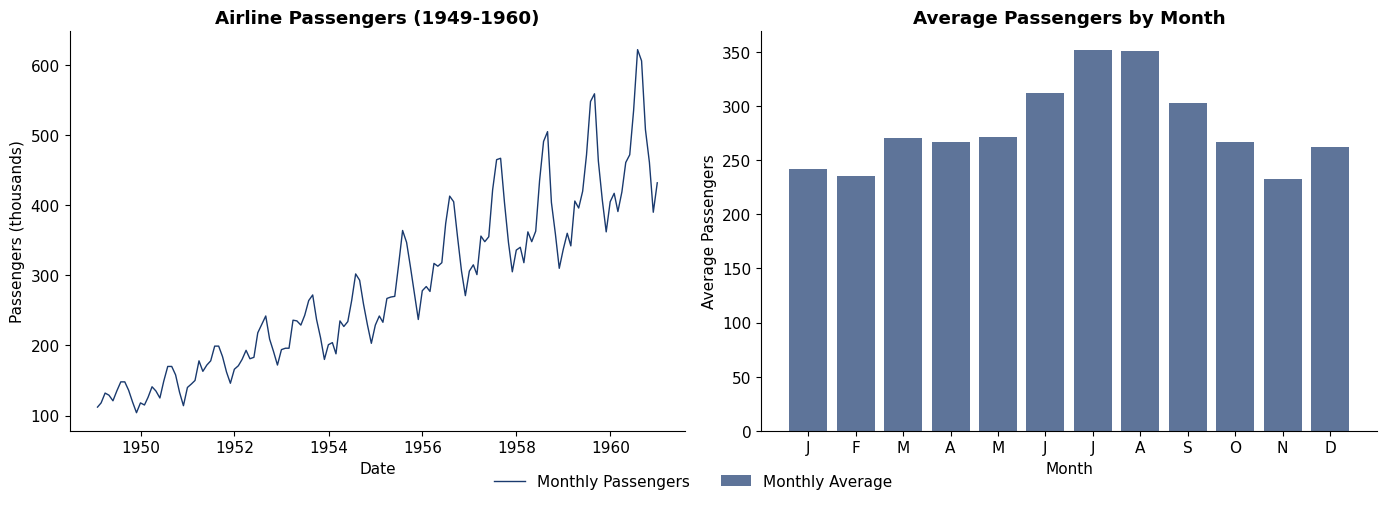

In [3]:
# Plot the airline passengers data
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original data
axes[0].plot(airline.index, airline['Passengers'], color=COLORS['blue'], linewidth=1, label='Monthly Passengers')
axes[0].set_title('Airline Passengers (1949-1960)', fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Passengers (thousands)')

# Seasonal subseries plot - show each month's pattern
monthly_means = airline.groupby(airline.index.month).mean()
axes[1].bar(range(1, 13), monthly_means['Passengers'].values, color=COLORS['blue'], alpha=0.7, label='Monthly Average')
axes[1].set_title('Average Passengers by Month', fontweight='bold')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Average Passengers')
axes[1].set_xticks(range(1, 13))
axes[1].set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])

# Collect handles and labels from all axes
handles, labels = [], []
for ax in axes:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.02))
plt.subplots_adjust(bottom=0.15)
plt.tight_layout()
plt.show()

In [4]:
print("Key observations:")
print("- Clear upward trend over time")
print("- Strong seasonal pattern (peaks in summer)")
print("- Seasonal amplitude GROWS with the level (multiplicative seasonality)")

Key observations:
- Clear upward trend over time
- Strong seasonal pattern (peaks in summer)
- Seasonal amplitude GROWS with the level (multiplicative seasonality)


## 2. Seasonal Decomposition

Time series with seasonality can be decomposed into:
- **Trend** ($T_t$): Long-term direction
- **Seasonal** ($S_t$): Repeating pattern
- **Residual** ($R_t$): Random noise

### Decomposition Types
- **Additive**: $Y_t = T_t + S_t + R_t$ (constant seasonal amplitude)
- **Multiplicative**: $Y_t = T_t \times S_t \times R_t$ (growing seasonal amplitude)

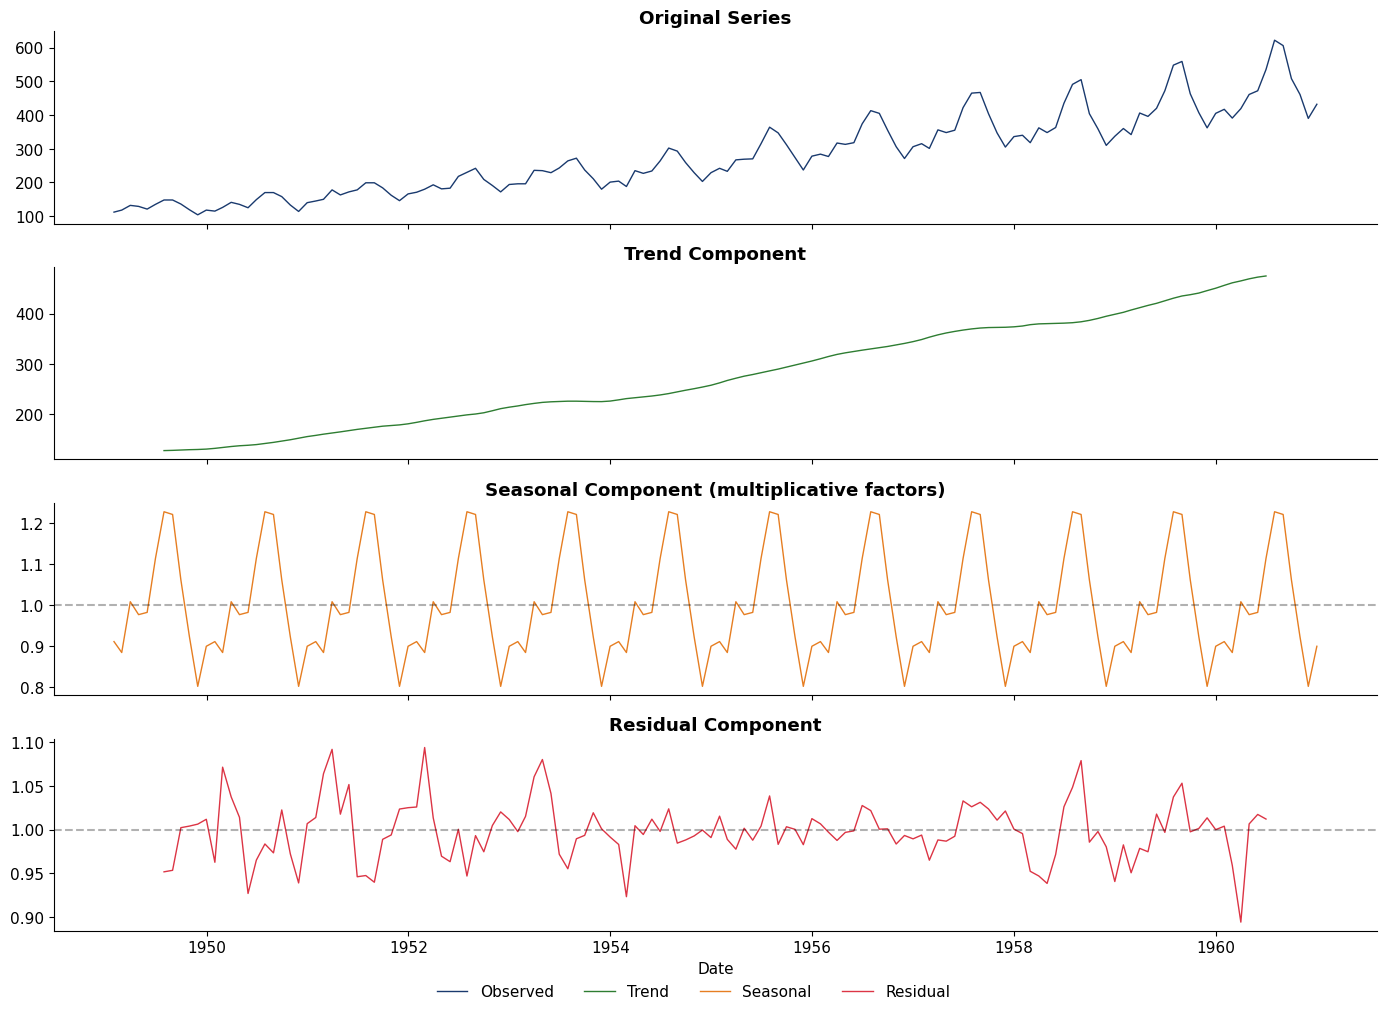

In [5]:
# Perform seasonal decomposition
decomposition = seasonal_decompose(airline['Passengers'], model='multiplicative', period=12)

fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

# Original
axes[0].plot(airline.index, airline['Passengers'], color=COLORS['blue'], linewidth=1, label='Observed')
axes[0].set_title('Original Series', fontweight='bold')

# Trend
axes[1].plot(airline.index, decomposition.trend, color=COLORS['green'], linewidth=1, label='Trend')
axes[1].set_title('Trend Component', fontweight='bold')

# Seasonal
axes[2].plot(airline.index, decomposition.seasonal, color=COLORS['orange'], linewidth=1, label='Seasonal')
axes[2].set_title('Seasonal Component (multiplicative factors)', fontweight='bold')
axes[2].axhline(y=1, color='black', linestyle='--', alpha=0.3)

# Residual
axes[3].plot(airline.index, decomposition.resid, color=COLORS['red'], linewidth=1, label='Residual')
axes[3].set_title('Residual Component', fontweight='bold')
axes[3].axhline(y=1, color='black', linestyle='--', alpha=0.3)
axes[3].set_xlabel('Date')

# Collect handles and labels from all axes
handles, labels = [], []
for ax in axes:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.02))
plt.subplots_adjust(bottom=0.08)
plt.tight_layout()
plt.show()

In [6]:
print("\nSeasonal factors (multiplicative):")
seasonal_factors = decomposition.seasonal.iloc[:12]
for i, (month, factor) in enumerate(zip(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], 
                                         seasonal_factors)):
    print(f"  {month}: {factor:.3f} ({(factor-1)*100:+.1f}% from average)")


Seasonal factors (multiplicative):
  Jan: 0.910 (-9.0% from average)
  Feb: 0.884 (-11.6% from average)
  Mar: 1.007 (+0.7% from average)
  Apr: 0.976 (-2.4% from average)
  May: 0.981 (-1.9% from average)
  Jun: 1.113 (+11.3% from average)
  Jul: 1.227 (+22.7% from average)
  Aug: 1.220 (+22.0% from average)
  Sep: 1.060 (+6.0% from average)
  Oct: 0.922 (-7.8% from average)
  Nov: 0.801 (-19.9% from average)
  Dec: 0.899 (-10.1% from average)


## 3. The Seasonal Differencing Operator

For data with period $s$, the **seasonal difference** is:

$$(1 - L^s)Y_t = Y_t - Y_{t-s}$$

### Examples
- Monthly data ($s=12$): $(1-L^{12})Y_t = Y_t - Y_{t-12}$
- Quarterly data ($s=4$): $(1-L^4)Y_t = Y_t - Y_{t-4}$

### Full Differencing for Trend + Seasonality
$$(1-L)(1-L^s)Y_t = (Y_t - Y_{t-1}) - (Y_{t-s} - Y_{t-s-1})$$

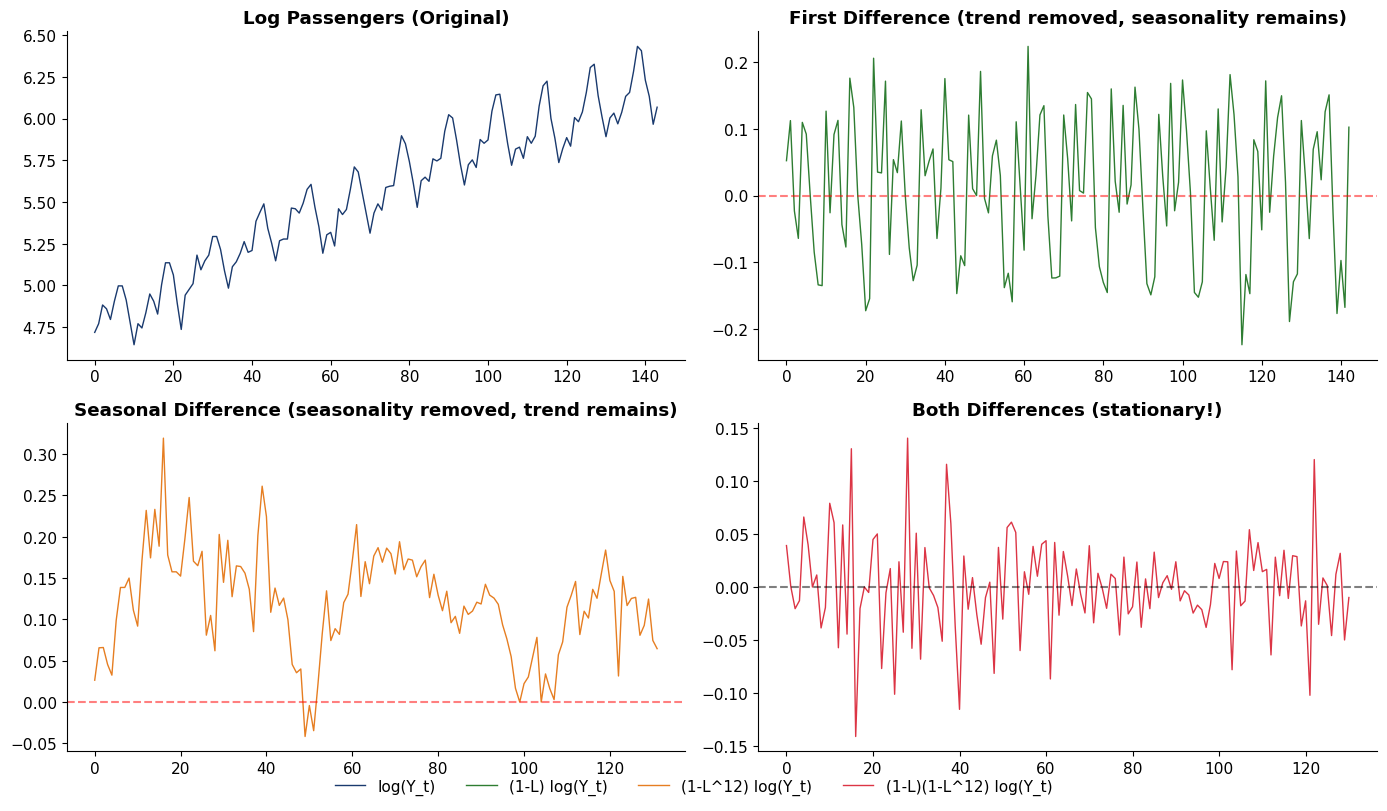

In [7]:
# Apply different differencing operators
y = airline['Passengers'].values

# Log transform first (for multiplicative seasonality)
log_y = np.log(y)

# First difference (removes trend)
diff1 = np.diff(log_y)

# Seasonal difference (removes seasonality)
diff12 = log_y[12:] - log_y[:-12]

# Both differences (removes both)
diff1_12 = diff12[1:] - diff12[:-1]

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Original log series
axes[0, 0].plot(log_y, color=COLORS['blue'], linewidth=1, label='log(Y_t)')
axes[0, 0].set_title('Log Passengers (Original)', fontweight='bold')

# First difference only
axes[0, 1].plot(diff1, color=COLORS['green'], linewidth=1, label='(1-L) log(Y_t)')
axes[0, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[0, 1].set_title('First Difference (trend removed, seasonality remains)', fontweight='bold')

# Seasonal difference only
axes[1, 0].plot(diff12, color=COLORS['orange'], linewidth=1, label='(1-L^12) log(Y_t)')
axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1, 0].set_title('Seasonal Difference (seasonality removed, trend remains)', fontweight='bold')

# Both differences
axes[1, 1].plot(diff1_12, color=COLORS['red'], linewidth=1, label='(1-L)(1-L^12) log(Y_t)')
axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1, 1].set_title('Both Differences (stationary!)', fontweight='bold')

# Collect handles and labels from all axes
handles, labels = [], []
for ax_row in axes:
    for ax in ax_row:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)

fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.02))
plt.subplots_adjust(bottom=0.1)
plt.tight_layout()
plt.show()

In [8]:
# Unit root tests to verify stationarity
def run_adf_test(series, name):
    """Run ADF test and print results."""
    series_clean = series[~np.isnan(series)]
    result = adfuller(series_clean, autolag='AIC')
    print(f"\n{name}:")
    print(f"  ADF Statistic: {result[0]:.4f}")
    print(f"  p-value: {result[1]:.6f}")
    print(f"  Conclusion: {'STATIONARY' if result[1] < 0.05 else 'NON-STATIONARY'}")

print("="*60)
print("ADF Tests for Different Transformations")
print("="*60)
run_adf_test(log_y, "Log Passengers")
run_adf_test(diff1, "First Difference of Log")
run_adf_test(diff12, "Seasonal Difference of Log")
run_adf_test(diff1_12, "Both Differences")

ADF Tests for Different Transformations

Log Passengers:
  ADF Statistic: -1.7170
  p-value: 0.422367
  Conclusion: NON-STATIONARY

First Difference of Log:
  ADF Statistic: -2.7171
  p-value: 0.071121
  Conclusion: NON-STATIONARY

Seasonal Difference of Log:
  ADF Statistic: -2.7096
  p-value: 0.072396
  Conclusion: NON-STATIONARY

Both Differences:
  ADF Statistic: -4.4433
  p-value: 0.000249
  Conclusion: STATIONARY


## 4. SARIMA Model Structure

**SARIMA**$(p,d,q) \times (P,D,Q)_s$ combines:

| Component | Meaning |
|-----------|--------|
| $p$ | Non-seasonal AR order |
| $d$ | Non-seasonal differencing |
| $q$ | Non-seasonal MA order |
| $P$ | Seasonal AR order |
| $D$ | Seasonal differencing |
| $Q$ | Seasonal MA order |
| $s$ | Seasonal period |

### The Full Model
$$\phi(L)\Phi(L^s)(1-L)^d(1-L^s)^D Y_t = c + \theta(L)\Theta(L^s)\varepsilon_t$$

where:
- $\phi(L) = 1 - \phi_1 L - \cdots - \phi_p L^p$ (non-seasonal AR)
- $\Phi(L^s) = 1 - \Phi_1 L^s - \cdots - \Phi_P L^{Ps}$ (seasonal AR)
- $\theta(L) = 1 + \theta_1 L + \cdots + \theta_q L^q$ (non-seasonal MA)
- $\Theta(L^s) = 1 + \Theta_1 L^s + \cdots + \Theta_Q L^{Qs}$ (seasonal MA)

## 5. The Airline Model: SARIMA$(0,1,1) \times (0,1,1)_{12}$

The classic **airline model** introduced by Box & Jenkins (1970):

$$(1-L)(1-L^{12})Y_t = (1 + \theta_1 L)(1 + \Theta_1 L^{12})\varepsilon_t$$

### Expanded Form
$$Y_t - Y_{t-1} - Y_{t-12} + Y_{t-13} = \varepsilon_t + \theta_1 \varepsilon_{t-1} + \Theta_1 \varepsilon_{t-12} + \theta_1 \Theta_1 \varepsilon_{t-13}$$

Only **2 parameters** ($\theta_1, \Theta_1$) yet captures complex seasonal dynamics!

In [9]:
# Fit the airline model to log passengers
model = SARIMAX(log_y, 
                order=(0, 1, 1), 
                seasonal_order=(0, 1, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=False)

print("Airline Model: SARIMA(0,1,1)(0,1,1)[12]")
print("="*60)
print(results.summary())

Airline Model: SARIMA(0,1,1)(0,1,1)[12]
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 220.722
Date:                            Sun, 18 Jan 2026   AIC                           -435.444
Time:                                    17:07:38   BIC                           -427.157
Sample:                                         0   HQIC                          -432.079
                                            - 144                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4327      0.075     -5.750      0.000      -0.580      -0

In [10]:
# Interpret the coefficients
# Create a dict from param names and values for easy access
params_dict = dict(zip(results.param_names, results.params))

print("\nCoefficient Interpretation:")
print("="*50)
print(f"θ₁ (ma.L1) = {params_dict['ma.L1']:.4f}")
print(f"Θ₁ (ma.S.L12) = {params_dict['ma.S.L12']:.4f}")
print(f"σ² = {params_dict['sigma2']:.6f}")
print("\nBoth MA coefficients are negative (typical for this data):")
print("- Negative θ₁: Positive shocks partially reverse next month")
print("- Negative Θ₁: Positive shocks partially reverse next year")


Coefficient Interpretation:
θ₁ (ma.L1) = -0.4327
Θ₁ (ma.S.L12) = -0.5476
σ² = 0.001333

Both MA coefficients are negative (typical for this data):
- Negative θ₁: Positive shocks partially reverse next month
- Negative Θ₁: Positive shocks partially reverse next year


## 6. ACF/PACF Analysis for Seasonal Data

For seasonal data, look for patterns at:
- **Non-seasonal lags**: 1, 2, 3, ... (regular ARMA patterns)
- **Seasonal lags**: $s$, $2s$, $3s$, ... (e.g., 12, 24, 36 for monthly)

### Pattern Recognition
| If you see... | Consider... |
|---------------|------------|
| ACF cuts off at lag $s$ | Seasonal MA ($Q$) |
| PACF cuts off at lag $s$ | Seasonal AR ($P$) |
| Both decay at seasonal lags | Mixed seasonal ARMA |

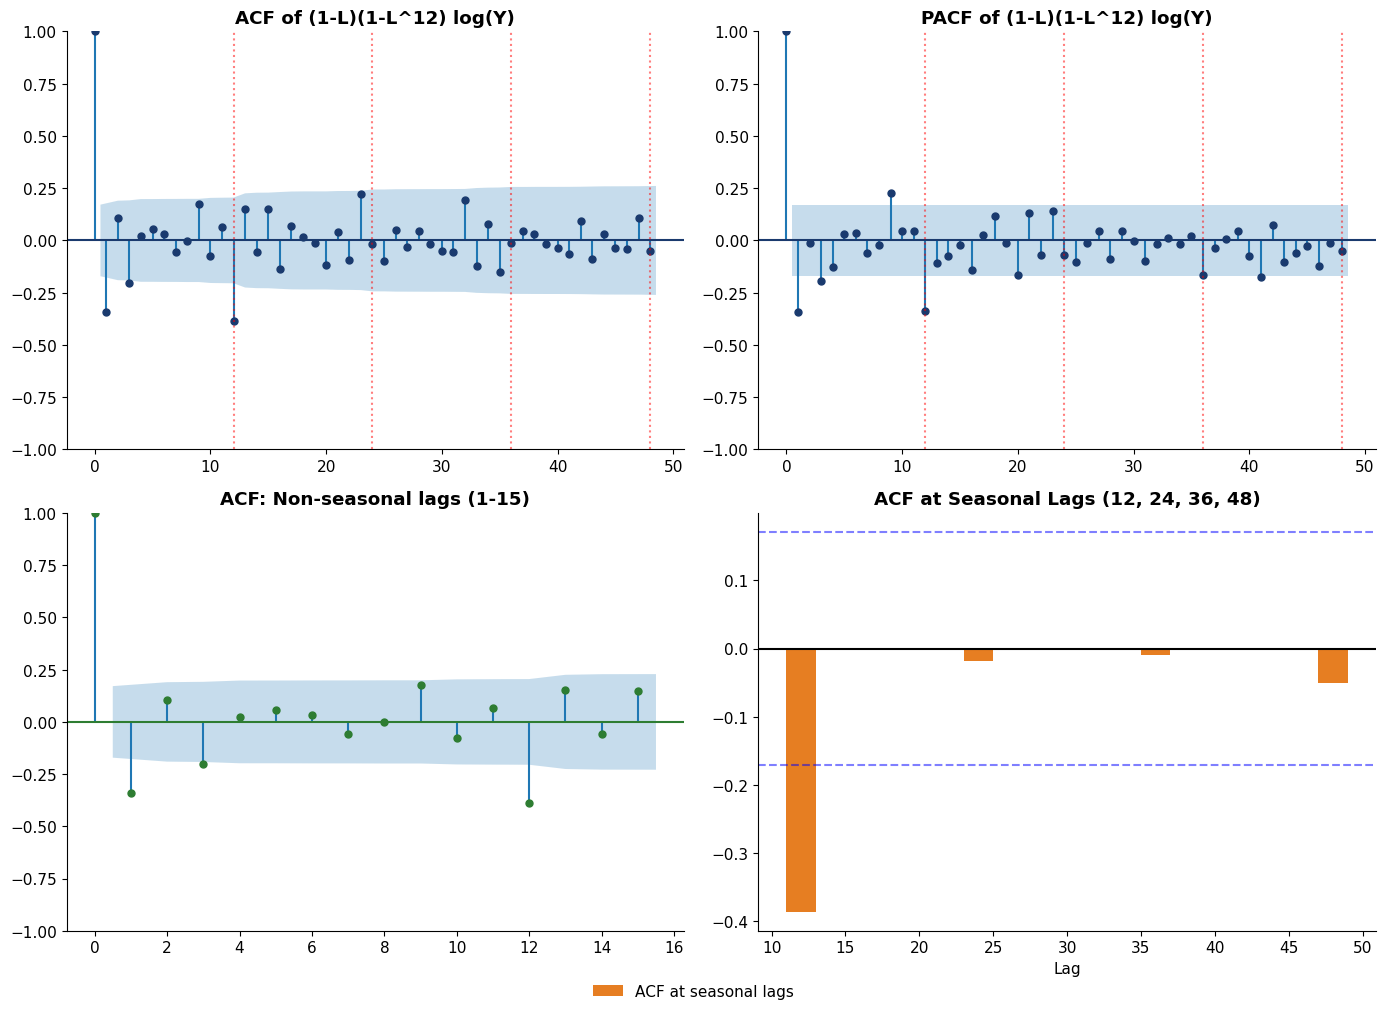

In [11]:
# ACF and PACF of differenced series
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ACF of (1-L)(1-L^12) log Y
plot_acf(diff1_12, ax=axes[0, 0], lags=48, color=COLORS['blue'])
axes[0, 0].set_title('ACF of (1-L)(1-L^12) log(Y)', fontweight='bold')
# Mark seasonal lags
for lag in [12, 24, 36, 48]:
    axes[0, 0].axvline(x=lag, color='red', linestyle=':', alpha=0.5)

# PACF of (1-L)(1-L^12) log Y
plot_pacf(diff1_12, ax=axes[0, 1], lags=48, color=COLORS['blue'])
axes[0, 1].set_title('PACF of (1-L)(1-L^12) log(Y)', fontweight='bold')
for lag in [12, 24, 36, 48]:
    axes[0, 1].axvline(x=lag, color='red', linestyle=':', alpha=0.5)

# Zoom in on first 15 lags
plot_acf(diff1_12, ax=axes[1, 0], lags=15, color=COLORS['green'])
axes[1, 0].set_title('ACF: Non-seasonal lags (1-15)', fontweight='bold')

# Show only seasonal lags in a bar chart
acf_vals = acf(diff1_12, nlags=48)
seasonal_lags = [12, 24, 36, 48]
seasonal_acf = [acf_vals[lag] for lag in seasonal_lags]
axes[1, 1].bar(seasonal_lags, seasonal_acf, color=COLORS['orange'], width=2, label='ACF at seasonal lags')
axes[1, 1].axhline(y=0, color='black', linestyle='-')
axes[1, 1].axhline(y=1.96/np.sqrt(len(diff1_12)), color='blue', linestyle='--', alpha=0.5)
axes[1, 1].axhline(y=-1.96/np.sqrt(len(diff1_12)), color='blue', linestyle='--', alpha=0.5)
axes[1, 1].set_title('ACF at Seasonal Lags (12, 24, 36, 48)', fontweight='bold')
axes[1, 1].set_xlabel('Lag')

# Collect handles and labels from bottom-right axes (the only one with legend)
handles, labels = axes[1, 1].get_legend_handles_labels()

fig.legend(handles, labels, loc='lower center', ncol=1, bbox_to_anchor=(0.5, -0.02))
plt.subplots_adjust(bottom=0.08)
plt.tight_layout()
plt.show()

In [12]:
print("\nACF/PACF Interpretation:")
print("- Significant spike at lag 1 in ACF → MA(1) component")
print("- Significant spike at lag 12 in ACF → Seasonal MA(1) component")
print("- This suggests SARIMA(0,1,1)(0,1,1)[12] - the airline model!")


ACF/PACF Interpretation:
- Significant spike at lag 1 in ACF → MA(1) component
- Significant spike at lag 12 in ACF → Seasonal MA(1) component
- This suggests SARIMA(0,1,1)(0,1,1)[12] - the airline model!


## 7. Model Diagnostics

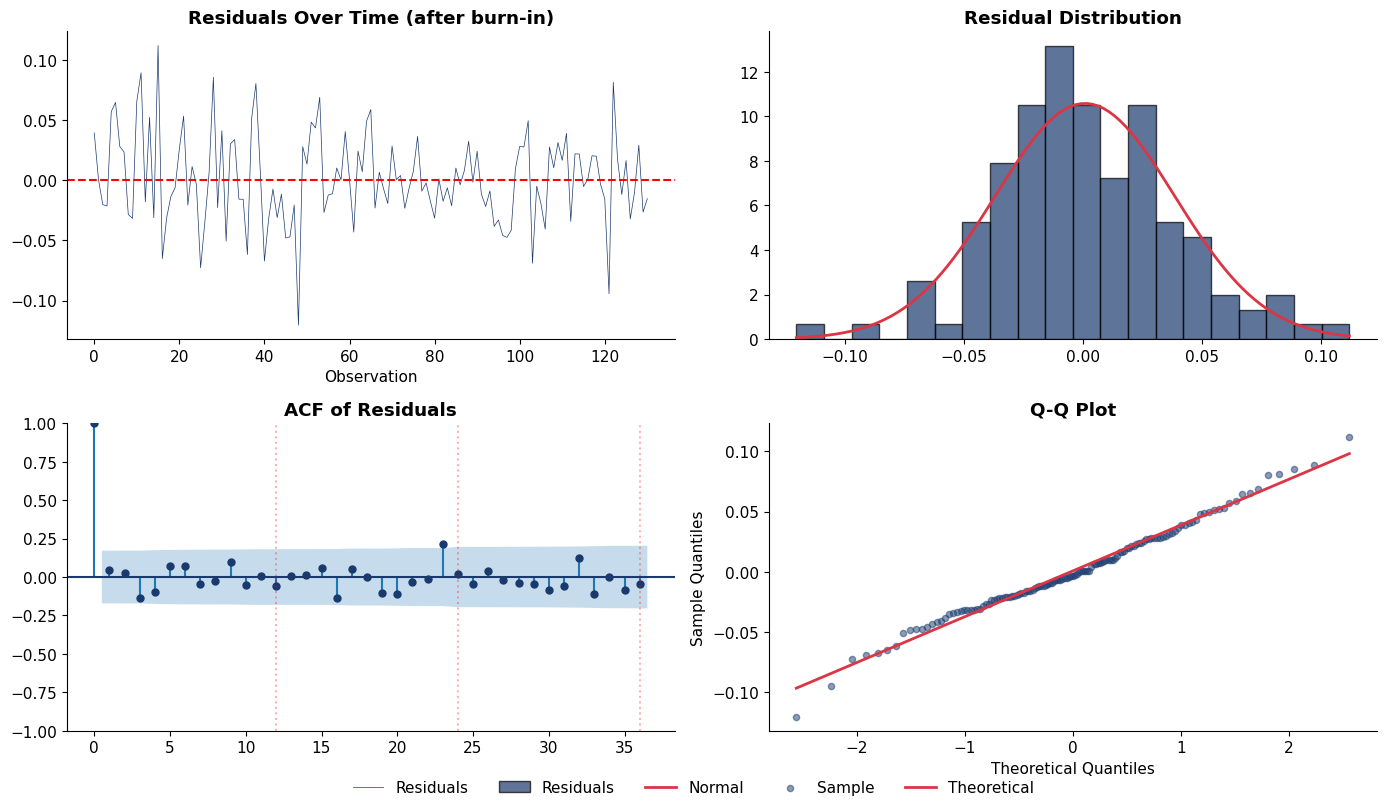

In [13]:
# Diagnostic plots
# Skip first 13 residuals (burn-in for seasonal model with s=12)
residuals_full = results.resid
residuals = np.array(residuals_full[13:])  # Convert to numpy array, skip burn-in

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Residuals over time
axes[0, 0].plot(range(len(residuals)), residuals, color=COLORS['blue'], linewidth=0.5, label='Residuals')
axes[0, 0].axhline(y=0, color='red', linestyle='--')
axes[0, 0].set_title('Residuals Over Time (after burn-in)', fontweight='bold')
axes[0, 0].set_xlabel('Observation')

# Histogram
axes[0, 1].hist(residuals, bins=20, color=COLORS['blue'], edgecolor='black', 
                alpha=0.7, density=True, label='Residuals')
x = np.linspace(residuals.min(), residuals.max(), 100)
axes[0, 1].plot(x, stats.norm.pdf(x, residuals.mean(), residuals.std()), 
                color=COLORS['red'], linewidth=2, label='Normal')
axes[0, 1].set_title('Residual Distribution', fontweight='bold')

# ACF of residuals
plot_acf(residuals, ax=axes[1, 0], lags=36, color=COLORS['blue'])
axes[1, 0].set_title('ACF of Residuals', fontweight='bold')
for lag in [12, 24, 36]:
    axes[1, 0].axvline(x=lag, color='red', linestyle=':', alpha=0.3)

# Q-Q plot
(osm, osr), (slope, intercept, r) = stats.probplot(residuals, dist="norm")
axes[1, 1].scatter(osm, osr, color=COLORS['blue'], s=20, alpha=0.5, label='Sample')
axes[1, 1].plot(osm, slope*osm + intercept, color=COLORS['red'], linewidth=2, label='Theoretical')
axes[1, 1].set_title('Q-Q Plot', fontweight='bold')
axes[1, 1].set_xlabel('Theoretical Quantiles')
axes[1, 1].set_ylabel('Sample Quantiles')

# Collect handles and labels from all axes
handles, labels = [], []
for ax_row in axes:
    for ax in ax_row:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)

fig.legend(handles, labels, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.02))
plt.subplots_adjust(bottom=0.1)
plt.tight_layout()
plt.show()

In [14]:
print(f"\nNote: First 13 residuals skipped (model burn-in period for seasonal order s=12)")


Note: First 13 residuals skipped (model burn-in period for seasonal order s=12)


In [15]:
# Ljung-Box test
lb_test = acorr_ljungbox(residuals, lags=[12, 24, 36], return_df=True)
print("Ljung-Box Test for Residual Autocorrelation:")
print("="*50)
print(lb_test)
print("\nInterpretation:")
print("If all p-values > 0.05, residuals are white noise (model is adequate)")

Ljung-Box Test for Residual Autocorrelation:
      lb_stat  lb_pvalue
12   8.383947   0.754453
24  23.462509   0.492651
36  33.056932   0.609324

Interpretation:
If all p-values > 0.05, residuals are white noise (model is adequate)


## 8. Model Selection with Auto-SARIMA

In [16]:
# Install pmdarima if needed
try:
    import pmdarima as pm
    print("pmdarima is available")
except ImportError:
    print("Installing pmdarima...")
    !pip install pmdarima -q
    import pmdarima as pm
    print("pmdarima installed successfully")

pmdarima is available


In [17]:
# Use auto_arima to find the best SARIMA model
import pmdarima as pm

auto_model = pm.auto_arima(
    log_y,
    start_p=0, start_q=0,
    max_p=2, max_q=2,
    d=1,           # Non-seasonal differencing
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    D=1,           # Seasonal differencing
    m=12,          # Seasonal period
    seasonal=True,
    stepwise=True,
    suppress_warnings=True,
    trace=True
)

print("\n" + "="*60)
print("Auto-SARIMA Selected Model:")
print("="*60)
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-434.830, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-474.813, Time=0.11 sec


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-483.393, Time=0.39 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-449.978, Time=0.04 sec


 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-481.906, Time=0.93 sec


 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-481.956, Time=2.46 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-477.399, Time=0.15 sec


 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-479.902, Time=0.68 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-467.553, Time=0.11 sec


 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-481.893, Time=0.53 sec


 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-481.610, Time=0.36 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-481.484, Time=0.20 sec


 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-479.399, Time=0.35 sec


 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=-481.421, Time=0.45 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]          
Total fit time: 6.780 seconds

Auto-SARIMA Selected Model:
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 244.696
Date:                            Sun, 18 Jan 2026   AIC                           -483.393
Time:                                    17:07:46   BIC                           -474.767
Sample:                                         0   HQIC                          -479.888
                                            - 144                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------

In [18]:
# Compare different SARIMA specifications
print("Model Comparison:")
print("="*70)
print(f"{'Model':<35} {'AIC':>12} {'BIC':>12}")
print("-"*70)

models_to_try = [
    ((0, 1, 1), (0, 1, 1, 12)),  # Airline model
    ((1, 1, 0), (1, 1, 0, 12)),  # Pure AR
    ((1, 1, 1), (0, 1, 1, 12)),  # Mixed
    ((0, 1, 1), (1, 1, 1, 12)),  # Extended seasonal
    ((1, 1, 1), (1, 1, 1, 12)),  # Full model
]

best_aic = float('inf')
best_model_name = None

for order, seasonal_order in models_to_try:
    try:
        model = SARIMAX(log_y, order=order, seasonal_order=seasonal_order,
                        enforce_stationarity=False, enforce_invertibility=False)
        res = model.fit(disp=False)
        model_name = f"SARIMA{order}x{seasonal_order[:3]}[{seasonal_order[3]}]"
        print(f"{model_name:<35} {res.aic:>12.2f} {res.bic:>12.2f}")
        if res.aic < best_aic:
            best_aic = res.aic
            best_model_name = model_name
    except Exception as e:
        pass

print("-"*70)
print(f"Best model by AIC: {best_model_name}")

Model Comparison:
Model                                        AIC          BIC
----------------------------------------------------------------------


SARIMA(0, 1, 1)x(0, 1, 1)[12]            -435.44      -427.16
SARIMA(1, 1, 0)x(1, 1, 0)[12]            -431.33      -423.02


SARIMA(1, 1, 1)x(0, 1, 1)[12]            -433.79      -422.74
SARIMA(0, 1, 1)x(1, 1, 1)[12]            -428.87      -417.82


SARIMA(1, 1, 1)x(1, 1, 1)[12]            -427.03      -413.22
----------------------------------------------------------------------
Best model by AIC: SARIMA(0, 1, 1)x(0, 1, 1)[12]


## 9. Forecasting with SARIMA

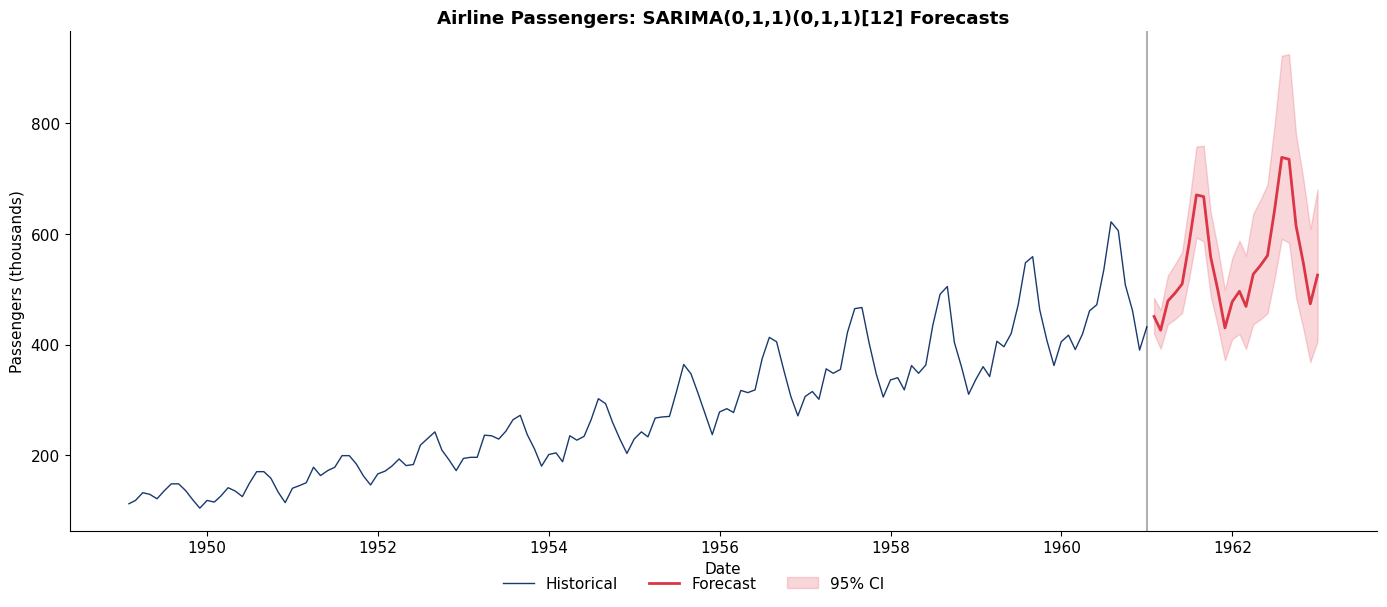

In [19]:
# Generate forecasts
forecast_steps = 24  # 2 years ahead
forecast = results.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Convert back from log scale
forecast_passengers = np.exp(forecast_mean)
# Handle both DataFrame and numpy array cases
if hasattr(forecast_ci, "iloc"):
    ci_lower = np.exp(forecast_ci.iloc[:, 0])
    ci_upper = np.exp(forecast_ci.iloc[:, 1])
else:
    ci_lower = np.exp(forecast_ci[:, 0])
    ci_upper = np.exp(forecast_ci[:, 1])

# Create forecast dates
last_date = airline.index[-1]
forecast_dates = pd.date_range(start=last_date, periods=forecast_steps+1, freq='ME')[1:]

# Plot
fig, ax = plt.subplots(figsize=(14, 6))

# Historical data
ax.plot(airline.index, airline['Passengers'], color=COLORS['blue'], linewidth=1, label='Historical')

# Forecasts
ax.plot(forecast_dates, forecast_passengers, color=COLORS['red'], linewidth=2, label='Forecast')

# Confidence interval
ax.fill_between(forecast_dates, ci_lower, ci_upper,
                color=COLORS['red'], alpha=0.2, label='95% CI')

ax.axvline(x=last_date, color='black', linestyle='-', alpha=0.3)
ax.set_xlabel('Date')
ax.set_ylabel('Passengers (thousands)')
ax.set_title('Airline Passengers: SARIMA(0,1,1)(0,1,1)[12] Forecasts', fontweight='bold')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.02))
plt.subplots_adjust(bottom=0.15)
plt.tight_layout()
plt.show()

In [20]:
print(f"\nForecast Summary (next 12 months):")
print("="*50)
for i in range(12):
    print(f"{forecast_dates[i].strftime('%Y-%m')}: {forecast_passengers[i]:.0f} "
          f"[{ci_lower[i]:.0f}, {ci_upper[i]:.0f}]")


Forecast Summary (next 12 months):
1961-01: 451 [420, 484]
1961-02: 426 [392, 462]
1961-03: 479 [437, 525]
1961-04: 493 [446, 545]
1961-05: 510 [457, 568]
1961-06: 584 [520, 655]
1961-07: 671 [593, 758]
1961-08: 668 [587, 760]
1961-09: 558 [488, 639]
1961-10: 498 [432, 573]
1961-11: 430 [371, 498]
1961-12: 477 [410, 556]


## 10. In-Sample Fit Evaluation

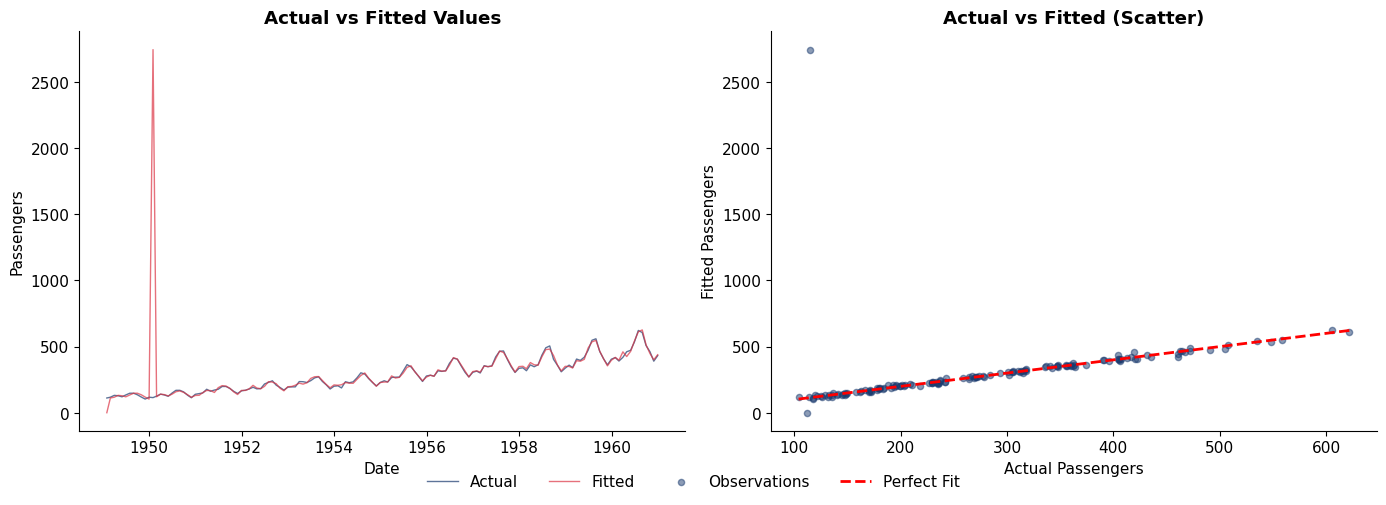

In [21]:
# Compare fitted values with actual
fitted = np.exp(results.fittedvalues)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Actual vs Fitted
axes[0].plot(airline.index, airline['Passengers'], color=COLORS['blue'], 
             linewidth=1, alpha=0.7, label='Actual')
axes[0].plot(airline.index, fitted, color=COLORS['red'], 
             linewidth=1, alpha=0.7, label='Fitted')
axes[0].set_title('Actual vs Fitted Values', fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Passengers')

# Scatter plot
axes[1].scatter(airline['Passengers'], fitted, alpha=0.5, color=COLORS['blue'], s=20, label='Observations')
axes[1].plot([airline['Passengers'].min(), airline['Passengers'].max()],
             [airline['Passengers'].min(), airline['Passengers'].max()],
             'r--', linewidth=2, label='Perfect Fit')
axes[1].set_xlabel('Actual Passengers')
axes[1].set_ylabel('Fitted Passengers')
axes[1].set_title('Actual vs Fitted (Scatter)', fontweight='bold')

# Collect handles and labels from all axes
handles, labels = [], []
for ax in axes:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.02))
plt.subplots_adjust(bottom=0.15)
plt.tight_layout()
plt.show()

In [22]:
# Calculate fit statistics
actual = airline['Passengers'].values
mape = np.mean(np.abs((actual - fitted) / actual)) * 100
rmse = np.sqrt(np.mean((actual - fitted)**2))
r2 = 1 - np.sum((actual - fitted)**2) / np.sum((actual - actual.mean())**2)

print(f"\nModel Fit Statistics:")
print(f"  MAPE: {mape:.2f}%")
print(f"  RMSE: {rmse:.2f}")
print(f"  R²: {r2:.4f}")


Model Fit Statistics:
  MAPE: 19.86%
  RMSE: 219.35
  R²: -2.3666


## 11. Rolling Forecast Evaluation

Rolling forecast evaluation (24 forecasts)...


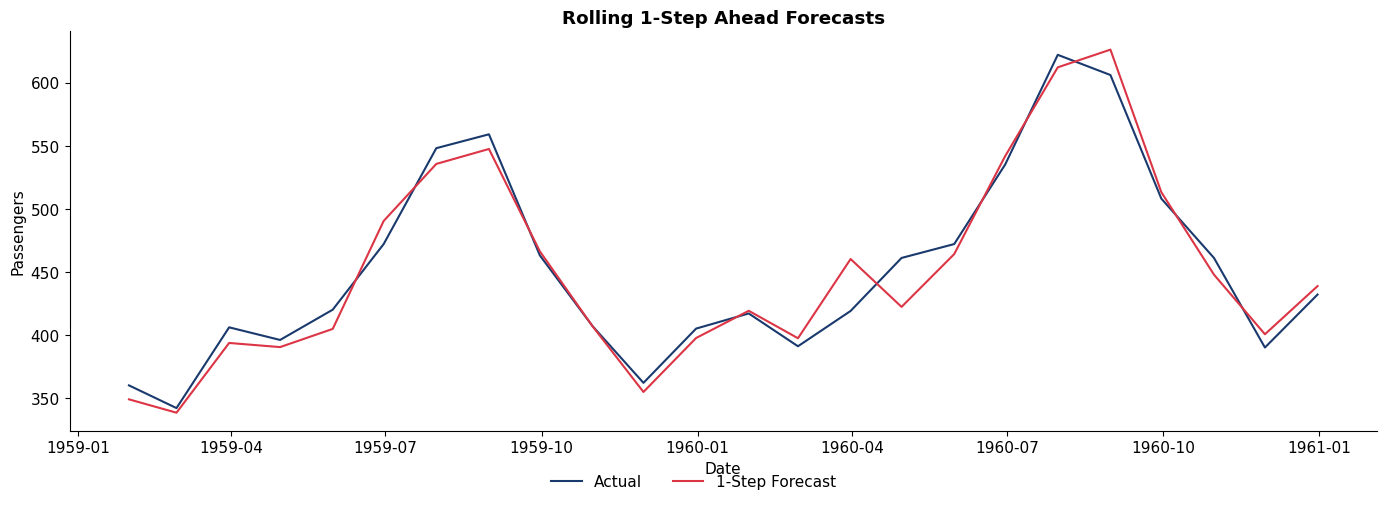

In [23]:
# Rolling origin forecast evaluation
train_size = 120  # Use first 10 years for training
test_size = len(log_y) - train_size

forecasts = []
actuals = []

print(f"Rolling forecast evaluation ({test_size} forecasts)...")

for i in range(test_size):
    # Fit model on expanding window
    train = log_y[:train_size + i]
    model = SARIMAX(train, order=(0, 1, 1), seasonal_order=(0, 1, 1, 12),
                    enforce_stationarity=False, enforce_invertibility=False)
    res = model.fit(disp=False)
    
    # 1-step ahead forecast
    fc = res.forecast(steps=1)
    # Handle both numpy array and pandas Series
    if hasattr(fc, 'values'):
        forecasts.append(np.exp(fc.values[0]))
    else:
        forecasts.append(np.exp(fc[0]))
    actuals.append(y[train_size + i])

forecasts = np.array(forecasts)
actuals = np.array(actuals)

# Calculate accuracy metrics
mape_oos = np.mean(np.abs((actuals - forecasts) / actuals)) * 100
rmse_oos = np.sqrt(np.mean((actuals - forecasts)**2))

# Plot
fig, ax = plt.subplots(figsize=(14, 5))

test_dates = airline.index[train_size:]
ax.plot(test_dates, actuals, color=COLORS['blue'], linewidth=1.5, label='Actual')
ax.plot(test_dates, forecasts, color=COLORS['red'], linewidth=1.5, label='1-Step Forecast')
ax.set_title('Rolling 1-Step Ahead Forecasts', fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.02))
plt.subplots_adjust(bottom=0.15)
plt.tight_layout()
plt.show()

In [24]:
print(f"\nOut-of-Sample Forecast Accuracy:")
print(f"  MAPE: {mape_oos:.2f}%")
print(f"  RMSE: {rmse_oos:.2f}")


Out-of-Sample Forecast Accuracy:
  MAPE: 2.56%
  RMSE: 15.15


## 12. Comparing SARIMA to Naive Seasonal Benchmark

In [25]:
# Seasonal naive: forecast = same month last year
naive_forecasts = y[train_size - 12: -12]  # Shift by 12 months

mape_naive = np.mean(np.abs((actuals - naive_forecasts) / actuals)) * 100
rmse_naive = np.sqrt(np.mean((actuals - naive_forecasts)**2))

print("Forecast Accuracy Comparison:")
print("="*50)
print(f"{'Method':<25} {'MAPE':>10} {'RMSE':>10}")
print("-"*50)
print(f"{'Seasonal Naive':<25} {mape_naive:>10.2f}% {rmse_naive:>10.2f}")
print(f"{'SARIMA(0,1,1)(0,1,1)[12]':<25} {mape_oos:>10.2f}% {rmse_oos:>10.2f}")
print("-"*50)

improvement = (mape_naive - mape_oos) / mape_naive * 100
print(f"\nSARIMA improvement over naive: {improvement:.1f}%")

Forecast Accuracy Comparison:
Method                          MAPE       RMSE
--------------------------------------------------
Seasonal Naive                 10.52%      49.99
SARIMA(0,1,1)(0,1,1)[12]        2.56%      15.15
--------------------------------------------------

SARIMA improvement over naive: 75.7%


## Summary

### Key Takeaways

1. **Seasonality** is a common feature in economic time series
   - Monthly, quarterly, weekly patterns
   - Can be deterministic or stochastic

2. **Seasonal differencing** $(1-L^s)$ removes stochastic seasonality
   - For monthly data: $(1-L^{12})Y_t = Y_t - Y_{t-12}$
   - Often combined with regular differencing

3. **SARIMA**$(p,d,q) \times (P,D,Q)_s$ combines:
   - Regular ARIMA components
   - Seasonal ARIMA components
   - Multiplicative structure for interactions

4. **The airline model** SARIMA$(0,1,1) \times (0,1,1)_{12}$:
   - Only 2 parameters
   - Works well for many seasonal series

5. **ACF/PACF patterns** appear at seasonal lags
   - Look for spikes at $s$, $2s$, $3s$, ...

6. **Auto-SARIMA** automates model selection
   - `pmdarima` package in Python

### Next Chapter
Chapter 5 will cover **multivariate time series**: VAR models, Granger causality, and cointegration.